In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time

import numpy as np

import collab2.foraging.toolkit as ft
from collab2.foraging.toolkit import plot_predictor
from collab2.utils import find_repo_root

logging.basicConfig(format="%(message)s", level=logging.INFO)

root = find_repo_root()

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
# smoke_test = True

smoke_test
smoke_test = "CI" in os.environ
subset_starts = 0
subset_ends = 1600 if smoke_test else 10000
desired_frames = 500 if smoke_test else 900
frame_spacing = 180 if smoke_test else 60
num_svi_iters = 10 if smoke_test else 1000
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 1000
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770

# developer_mode runs inference; if False, it loads saved version of the results
developer_mode = False
if developer_mode:
    smoke_test = False

notebook_starts = time.time()

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from collab2.foraging.toolkit import (
    dataObject,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)

locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")


def load_and_clean_locust(
    path=locust_data_path,
    frame_spacing=500,
    grid_size=45,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
):

    # loading and column names
    locust = pd.read_csv(path)
    locust.drop("cnt", axis=1, inplace=True)
    locust.rename(
        columns={"pos_x": "x", "pos_y": "y", "id": "forager", "frame": "time"},
        inplace=True,
    )
    locust = locust[["x", "y", "time", "forager"]]
    encoder = LabelEncoder()
    locust["forager"] = encoder.fit_transform(locust["forager"])
    locust["time"] = locust["time"] - locust["time"].min()

    locust_subset = locust[
        (locust["time"] >= subset_starts) & (locust["time"] <= subset_ends)
    ]

    locust_subsample = subsample_frames_constant_frame_rate(
        locust_subset, frame_spacing=frame_spacing
    )

    locust_scaled = rescale_to_grid(locust_subsample, size=grid_size)

    print(locust_scaled)

    time = list(locust_scaled["time"].unique())

    rewardsDF = pd.DataFrame(
        {
            "x": rewards_x * len(time),
            "y": rewards_y * len(time),
            "time": [t for t in time for _ in range(len(rewards_x))],
        }
    )

    def rescale_reward_to_grid(column, size):
        mapped = (column + 1) / 2
        rescaled = mapped
        rescaled = np.round(mapped * size - 1)
        return rescaled

    rewardsDF["x"] = rescale_reward_to_grid(rewardsDF["x"], grid_size)
    rewardsDF["y"] = rescale_reward_to_grid(rewardsDF["y"], grid_size)

    locust_object = dataObject(foragersDF=locust_scaled, rewardsDF=rewardsDF)

    return locust_object


# TODO move to a module


locust = load_and_clean_locust(
    path=locust_data_path,
    frame_spacing=frame_spacing,
    grid_size=45,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)

original_frames: 10001
original_shape: (150015, 4)
resulting_frames: 167
resulting_shape: (2505, 4)
         x     y  time  forager
0     30.0  41.0     0        0
1      8.0  23.0     0        1
2     40.0  27.0     0        2
3     22.0  43.0     0        3
4     18.0  39.0     0        4
...    ...   ...   ...      ...
2500  21.0   0.0   166       10
2501   5.0  21.0   166       11
2502   8.0  38.0   166       12
2503  32.0  40.0   166       13
2504  20.0   0.0   166       14

[2505 rows x 4 columns]


In [3]:
display(locust.foragersDF)
display(locust.rewardsDF)

,x,y,time,forager
0,30.0,41.0,0,0
1,31.0,41.0,1,0
2,30.0,41.0,2,0
3,30.0,41.0,3,0
4,29.0,42.0,4,0
...,...,...,...,...
2500,19.0,0.0,162,14
2501,20.0,0.0,163,14
2502,20.0,0.0,164,14
2503,20.0,0.0,165,14


,x,y,time
0,37.0,21.0,0
1,6.0,21.0,0
2,37.0,21.0,1
3,6.0,21.0,1
4,37.0,21.0,2
...,...,...,...
329,6.0,21.0,164
330,37.0,21.0,165
331,6.0,21.0,165
332,37.0,21.0,166


In [4]:
local_windows_kwargs = {
    "window_size": 100,  # in paper: locust sight goes beyond the grid
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

interaction_constraint_params = {
    "finders_tolerance": 4,
}

predictor_kwargs = {
    "proximity": {
        "interaction_length": locust.grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "repulsion_radius": 1.5,
        "optimal_distance": 4,
        "proximity_decay": 1,
    },
    "food": {
        "decay_factor": 0.5,
    },
    "access": {
        "decay_factor": 0.2,
    },
    "communication": {
        "interaction_length": 15,
        "interaction_constraint_params": interaction_constraint_params,
    },
}

score_kwargs = {
    "nextStep_linear": {"nonlinearity_exponent": 1},
    "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
}

derivedDF = ft.derive_predictors_and_scores(
    locust,
    local_windows_kwargs,
    predictor_kwargs=predictor_kwargs,
    score_kwargs=score_kwargs,
    dropna=True,
    add_scaled_values=True,
)

display(derivedDF.head())

2024-09-24 15:47:09,203 - proximity completed in 14.28 seconds.
2024-09-24 15:47:14,108 - food completed in 4.90 seconds.
2024-09-24 15:47:18,317 - access completed in 4.21 seconds.
2024-09-24 15:47:29,763 - communication completed in 11.45 seconds.
2024-09-24 15:47:32,972 - nextStep_linear completed in 3.21 seconds.
2024-09-24 15:47:36,153 - nextStep_sublinear completed in 3.18 seconds.
/home/rafal/s78projects/collab-creatures/collab2/foraging/toolkit/derive.py:56: UserWarning: 
                      Dropped 30375/5072625 frames from `derivedDF` due to NaN values.
                      Missing values can arise when computations depend on next/previous step positions
                      that are unavailable. See documentation of the corresponding predictor/score generating
                      functions for more information.
                      
  warnings.warn(


,x,y,distance_to_forager,time,forager,proximity,food,access,communication,distance_to_next_step,nextStep_linear,nextStep_sublinear,proximity_scaled,food_scaled,access_scaled,communication_scaled,nextStep_linear_scaled,nextStep_sublinear_scaled
0,0,0,50.803543,0,0,1.124138e-17,0.000018,0.000039,0.0,51.400389,0.000000,0.000000,0.5,0.000016,0.000018,0.0,0.000000,0.000000
1,0,1,50.000000,0,0,2.785187e-17,0.000029,0.000045,0.0,50.606324,0.015449,0.007754,0.5,0.000027,0.000025,0.0,0.015449,0.007754
2,0,2,49.203658,0,0,6.873571e-17,0.000047,0.000053,0.0,49.819675,0.030753,0.015497,0.5,0.000045,0.000032,0.0,0.030753,0.015497
3,0,3,48.414874,0,0,1.689202e-16,0.000076,0.000062,0.0,49.040799,0.045906,0.023223,0.5,0.000074,0.000042,0.0,0.045906,0.023223
4,0,4,47.634021,0,0,4.132578e-16,0.000122,0.000073,0.0,48.270074,0.060901,0.030929,0.5,0.000120,0.000052,0.0,0.060901,0.030929


In [5]:
locust.rewardsDF.head()

,x,y,time
0,37.0,21.0,0
1,6.0,21.0,0
2,37.0,21.0,1
3,6.0,21.0,1
4,37.0,21.0,2


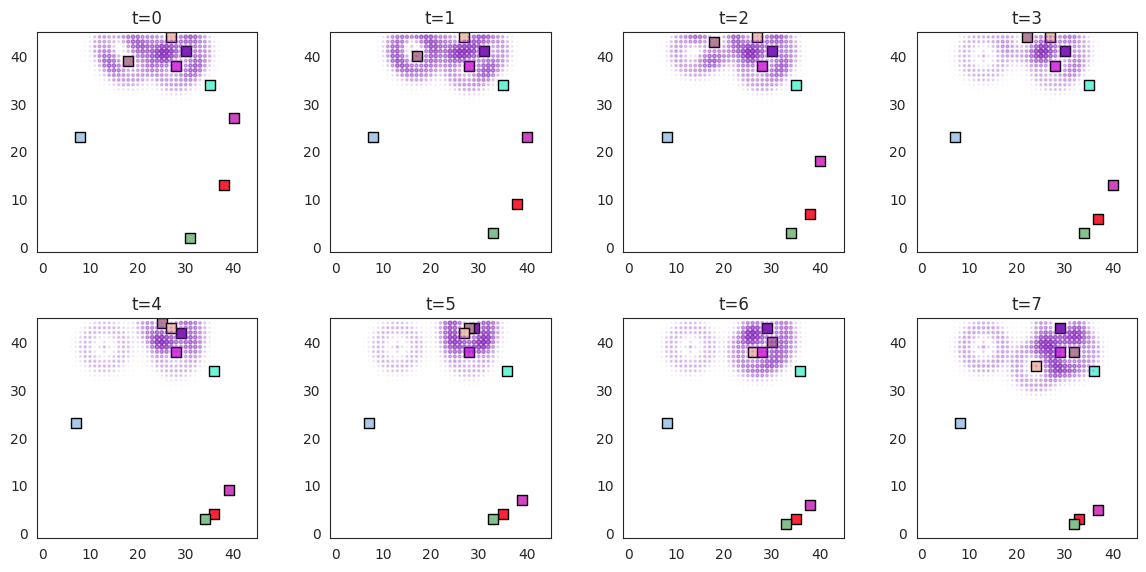

In [6]:
plot_predictor(
    locust.foragers,
    locust.derived_quantities["proximity"],
    predictor_name="proximity",
    time=range(8),
    grid_size=45,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=[0, 1, 2, 4, 5, 6, 7, 8, 9],
    forager_predictor_indices=[3],
)

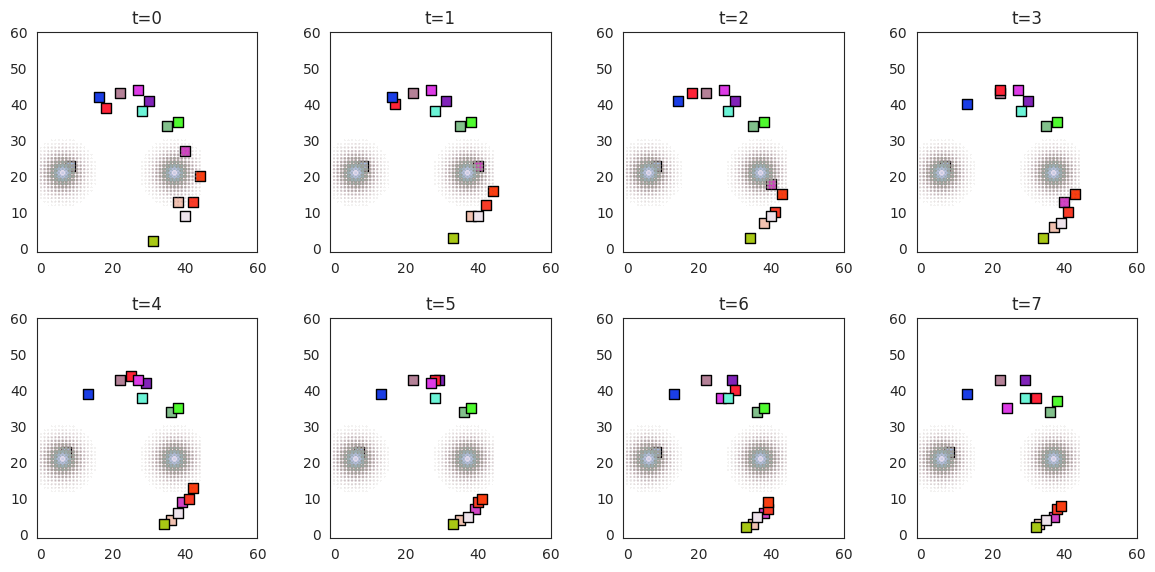

In [7]:
plot_predictor(
    locust.foragers,
    locust.derived_quantities["food"],
    predictor_name="food",
    time=range(8),
    grid_size=60,
    size_multiplier=10,
    random_state=99,
    forager_position_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    forager_predictor_indices=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
)

In [8]:
predictors = ["proximity_scaled", "food_scaled", "communication_scaled"]
outcome_vars = ["nextStep_sublinear"]


predictor_tensors_locust, outcome_tensor_locust = ft.prep_data_for_inference(
    locust,
    predictors,
    outcome_vars,
    subsample_rate=0.2,
)

Sample size: 1008450


In [10]:
ft.visualise_forager_predictors(
    predictors=[
        predictor_tensors_locust["proximity_scaled"],
        predictor_tensors_locust["food_scaled"],
        predictor_tensors_locust["communication_scaled"],
    ],
    predictor_names=["proximity_scaled", "food_scaled", "access_scaled"],
    outcome_name="nextStep_sublinear",
    outcome=outcome_tensor_locust["nextStep_sublinear"],
    sampling_rate=0.5,
)

2024-09-24 15:29:18,828 - Starting SVI inference with 1500 iterations.


[iteration 0001] loss: 4381961.5000
[iteration 0050] loss: 3871721.2500
[iteration 0100] loss: 4163290.7500
[iteration 0150] loss: 3097218.0000
[iteration 0200] loss: 3092450.2500
[iteration 0250] loss: 3052647.7500
[iteration 0300] loss: 3057922.7500
[iteration 0350] loss: 3030286.5000
[iteration 0400] loss: 3203373.0000
[iteration 0450] loss: 3007326.7500
[iteration 0500] loss: 3015907.2500
[iteration 0550] loss: 3002162.0000
[iteration 0600] loss: 3016756.2500
[iteration 0650] loss: 3006132.2500
[iteration 0700] loss: 3008879.2500
[iteration 0750] loss: 3011303.7500
[iteration 0800] loss: 3011334.0000
[iteration 0850] loss: 3006182.0000
[iteration 0900] loss: 2991568.2500
[iteration 0950] loss: 2997196.0000
[iteration 1000] loss: 3003587.7500
[iteration 1050] loss: 2999090.7500
[iteration 1100] loss: 3029861.5000
[iteration 1150] loss: 3000802.2500
[iteration 1200] loss: 2999920.0000
[iteration 1250] loss: 3035561.5000
[iteration 1300] loss: 2992702.2500
[iteration 1350] loss: 29840

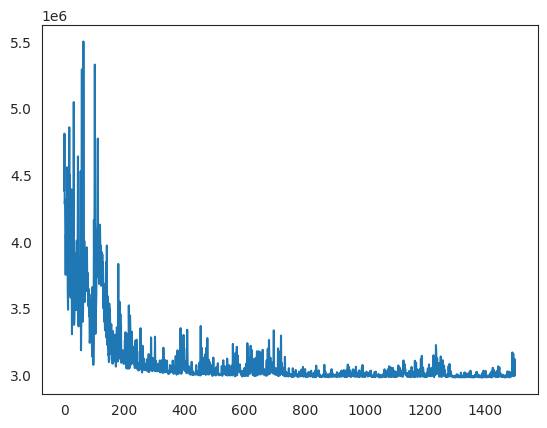

2024-09-24 15:30:34,411 - SVI inference completed in 75.58 seconds.


dict_keys(['bias_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_proximity_scaled_nextStep_sublinear', 'bias_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'bias_continuous_communication_scaled_nextStep_sublinear', 'weight_continuous_communication_scaled_nextStep_sublinear', 'bias_continuous_access_scaled_nextStep_sublinear', 'weight_continuous_access_scaled_nextStep_sublinear', 'bias_continuous_proximity_scaled_nextStep_sublinear_sigma', 'weight_continuous_proximity_scaled_nextStep_sublinear_sigma', 'bias_continuous_food_scaled_nextStep_sublinear_sigma', 'weight_continuous_food_scaled_nextStep_sublinear_sigma', 'bias_continuous_communication_scaled_nextStep_sublinear_sigma', 'weight_continuous_communication_scaled_nextStep_sublinear_sigma', 'bias_continuous_access_scaled_nextStep_sublinear_sigma', 'weight_continuous_access_scaled_nextStep_sublinear_sigma', 'proximity_scaled', 'food_scaled', 'communication_scaled', 'a

In [9]:
model_sigmavar_locust = ft.HeteroskedasticLinear(
    predictor_tensors_locust, outcome_tensor_locust
)

results_locust = ft.get_samples(
    model=model_sigmavar_locust,
    predictors=predictor_tensors_locust,
    outcome=outcome_tensor_locust,
    num_svi_iters=1500,
    num_samples=1000,
)

In [10]:
selected_sites = [
    key
    for key in results_locust["samples"].keys()
    if key.startswith("weight") and not key.endswith("sigma")
]
selected_samples = {key: results_locust["samples"][key] for key in selected_sites}

ft.plot_coefs(selected_samples, "Locust", nbins=120, ann_start_y=160, ann_break_y=50)